# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.461221,True,4.793862
1,0.099233,True,5.419175
2,0.782852,True,4.636391
3,-0.379173,False,-0.384632
4,1.890432,True,5.360473
...,...,...,...
995,1.941046,True,7.094734
996,-0.161197,True,6.045956
997,0.169117,True,3.326246
998,-0.556220,False,-0.697461


<AxesSubplot: xlabel='v0'>

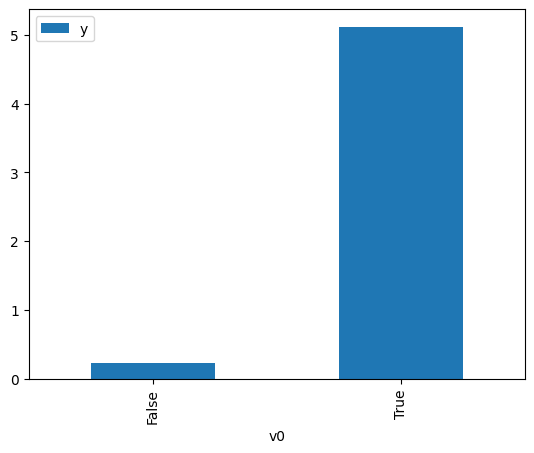

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

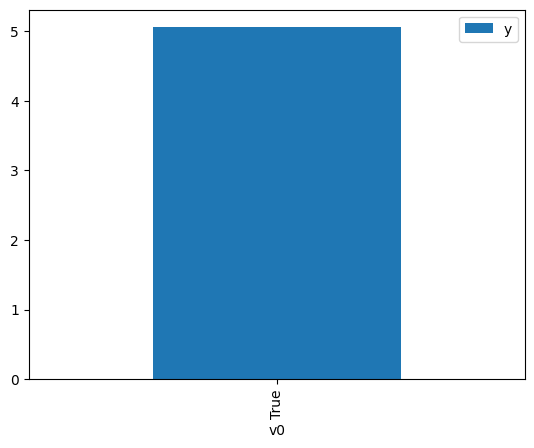

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.351699,False,1.197181,0.352726,2.835062
1,0.623526,False,0.404509,0.268875,3.719200
2,1.635053,False,-0.306407,0.078439,12.748680
3,2.315721,False,2.234705,0.030814,32.452630
4,0.962810,False,-0.023548,0.183743,5.442376
...,...,...,...,...,...
995,0.797790,False,1.353546,0.222276,4.498905
996,1.373753,False,0.868774,0.110493,9.050312
997,-0.556603,False,-0.851148,0.669735,1.493127
998,1.022495,False,2.886125,0.171145,5.843014


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.086913,True,4.370810,0.555768,1.799311
1,0.049345,True,3.617202,0.542312,1.843957
2,0.852590,True,5.225197,0.791127,1.264020
3,0.072122,True,5.627473,0.550479,1.816601
4,-0.180657,True,5.015345,0.459316,2.177150
...,...,...,...,...,...
995,0.511183,True,6.243790,0.698003,1.432658
996,1.769538,True,5.356616,0.934521,1.070067
997,0.462936,True,5.230462,0.683090,1.463937
998,0.257512,True,2.857095,0.615577,1.624493


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.947
Model:                            OLS   Adj. R-squared (uncentered):              0.947
Method:                 Least Squares   F-statistic:                              8945.
Date:                Fri, 31 Mar 2023   Prob (F-statistic):                        0.00
Time:                        14:08:00   Log-Likelihood:                         -1426.9
No. Observations:                1000   AIC:                                      2858.
Df Residuals:                     998   BIC:                                      2868.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.8130      0.037     22.058      0.000       0.741       0.885
x2             4.7954      0.049     97.177      0.000       4.699       4.892
==============================================================================
Omnibus:                        0.751   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.687   Jarque-Bera (JB):                0.658
Skew:                           0.057   Prob(JB):                        0.719
Kurtosis:                       3.052   Cond. No.                         2.02
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""